In [13]:
import pandas as pd
import numpy as np

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model, preprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
import time


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
%matplotlib inline
sns.set_style('white')


# 3.6.2 [Airline Arrivals](https://courses.thinkful.com/data-201v1/project/3.6.2)
Use this [dataset of airline arrival information](http://stat-computing.org/dataexpo/2009/the-data.html) to predict how late flights will be. A flight only counts as late if it is more than 30 minutes late.

File Location: 'unit_3_data/flight_delays.csv'

This problem is really a two stage question:
1. Predict if a flight is delayed (Classifier)
2. Predict how late (in minutes) a late flight will be (Regression)

The dataset provided includes cancelled flights which could be argued to be an extreme case of lateness or be deemed ineligible to be late since it will never arrive. For simiplicity I will remove cancelled flights.

### Hypothesis for flight delay:
* Certain airlines while have more frequent or longer delays (budget vs. premium airlines, differences in scheduling)
* Airports located near a densely populated city will have more traffic and more delays
* High traffic dow and holidays (especially in poor weather months like december) will have more delays
* Flights taking off later in the day will experience more delays in a cascading effect from the morning
* Long distance flights may be delayed more often (there is more that can go wrong with the additional distance and size of the plane)

### Hypothesis for length of delay:
* Delay type and number of delay types will contribute to length of delay
* The variable used to predict a flight delay occurring will probably also factor into length of that delay

### Given the above the variables I would like to include:
* 'Origin', 'Dest', 'Distance', 'AirTime', 'UniqueCarrier', 'CRSDepTime', 'Month', 'DayOfWeek' (but as flags, the order of busy-ness does not correlate with the order of the category), 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'

### Cleaning Data
This is a pretty large dataset. It will help to quickly remove variables that are not adding information relevent to the model.
1. Cancellation information will not be necessary since we removed cancelled flights, there may be a pattern with specific planes but it is unlikely that the tail numbers or flight numbers are assigned in a way that reflects similar plane types or flight types. I will also remove year because I am only using data from 2008. Also there are a bunch of planned and actual times.  ['Cancelled', 'CancellationCode', 'TailNum', 'FlightNum', 'Year']
2. Since our focus is arrival delay and the dataset is sufficiently large I will remove flights where arrival delay is null.
3. To answer the first question 'predict if a flight is delayed' I will need to add a column that is a flag for instances where the delay is > 30minutes
4. By defining 'late' as 30 minutes past scheduled time lateness really begins at 30 minutes past. Therefore late time should be adjusted in relationship to this marker.
5. For flights that are delayed it may help to turn the delay type into a flag instead of a time


In [3]:
df_airline = pd.DataFrame(pd.read_csv('flight_delays.csv'))
df_airline = df_airline[df_airline['Cancelled']==0]

In [6]:
df_airline.shape

(6872294, 29)

In [70]:
df_airline.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

In [73]:
df_airline[['CRSElapsedTime', 'ActualElapsedTime', 'AirTime']].head(10)

,CRSElapsedTime,ActualElapsedTime,AirTime
0,150.0,128.0,116.0
1,145.0,128.0,113.0
2,90.0,96.0,76.0
3,90.0,88.0,78.0
4,90.0,90.0,77.0
5,115.0,101.0,87.0
6,250.0,240.0,230.0
7,250.0,233.0,219.0
8,95.0,95.0,70.0
9,95.0,79.0,70.0


In [4]:
# 1. Drop unnecessary columns
df_air = df_airline.drop(['Cancelled', 'CancellationCode', 'Diverted',
                          'TailNum', 'FlightNum', 'Year', 'DepTime', 'TaxiOut',
                          'TaxiIn', 'ActualElapsedTime', 'ArrTime',
                          'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 
                          'LateAircraftDelay' ], axis=1)

# 2. Remove instances where arrival delay is null
df_air.dropna(axis=0, subset=['ArrDelay'], inplace=True)

# 3. Create flag delayed flight
df_air['delay_flag'] = np.where(df_air['ArrDelay']>=30, 1.0, 0.0)

# 4. Create late time feature that centers 0 at 30 minutes late
df_air['delay_time'] = df_air['ArrDelay']-30.0

In [79]:
df_air.describe().T

,count,mean,std,min,25%,50%,75%,max
Month,6855029.0,6.388525,3.398833,1.0,3.0,6.0,9.0,12.0
DayofMonth,6855029.0,15.738258,8.801086,1.0,8.0,16.0,23.0,31.0
DayOfWeek,6855029.0,3.925802,1.988459,1.0,2.0,4.0,6.0,7.0
CRSDepTime,6855029.0,1325.037277,464.312948,0.0,925.0,1317.0,1715.0,2359.0
CRSArrTime,6855029.0,1493.714708,482.664194,0.0,1115.0,1515.0,1905.0,2359.0
CRSElapsedTime,6855029.0,129.077814,69.532711,-141.0,80.0,111.0,159.0,660.0
AirTime,6855029.0,104.018589,67.439796,0.0,55.0,86.0,132.0,1350.0
ArrDelay,6855029.0,8.168452,38.501937,-519.0,-10.0,-2.0,12.0,2461.0
DepDelay,6855029.0,9.923845,35.203863,-534.0,-4.0,-1.0,8.0,2467.0
Distance,6855029.0,728.743834,563.244731,11.0,326.0,581.0,954.0,4962.0


Taking a look at our target variables delay flag and delay time we see that about 13.5% of flights that are not cancelled are delayed. Planes that Arrive 'on time' actually arrive 4 minutes before the scheduled arrival time on average. Late planes are a total of 59 minutes late typically.

In [15]:
df_air.groupby('delay_flag').describe()['delay_time'].round().T

delay_flag,0.0,1.0
count,5927614.0,927415.0
mean,-33.0,50.0
std,13.0,63.0
min,-549.0,0.0
25%,-41.0,11.0
50%,-34.0,29.0
75%,-26.0,66.0
max,-1.0,2431.0


In [16]:
df_air['delay_flag'].mean()

0.1352897267101277

In [80]:
df_air.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime',
       'UniqueCarrier', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay',
       'Origin', 'Dest', 'Distance', 'delay_flag', 'delay_time'],
      dtype='object')

In [5]:
df_air = df_air[['delay_flag', 'delay_time', 'Origin', 'Dest', 'UniqueCarrier', 'Distance', 'AirTime', 
                 'CRSDepTime', 'Month', 'DayOfWeek', ]]

In [6]:
def day_of_week(x):
    if x == 1:
        return "monday"
    elif x==2:
        return "tuesday"
    elif x==3:
        return "wednesday"
    elif x==4:
        return "thursday"
    elif x==5:
        return "friday"
    elif x==6:
        return "saturday"
    elif x==7:
        return "sunday"
df_air['DayOfWeek'] = df_air['DayOfWeek'].apply(lambda x: day_of_week(x))    
df_air['Month'] = df_air.Month.apply(lambda x: str(x))

### The size of this dataset is unweidley so I'm going to sample

In [69]:
df_air.columns

Index(['delay_flag', 'delay_time', 'Origin', 'Dest', 'Distance', 'AirTime',
       'CRSDepTime', 'Month', 'DayOfWeek'],
      dtype='object')

In [7]:
# Random Sample
df_air = df_air.sample(n=200000, random_state=42, replace=False)


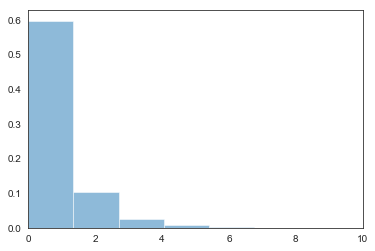

In [46]:
plt.hist(df_air[df_air['delay_flag']==1.0]['delay_time']/60.0, bins=30, label='delayed', alpha=0.5, density=True)
plt.xlim(0,10)

plt.title('Histogram of flight time delay in hours')
plt.show()

In [48]:
df_air.columns
continuous = ['delay_time', 'Distance', 'AirTime', 'CRSDepTime', 'Month', 'DepDelay']

In [49]:
df_air[continuous]

,delay_time,Distance,AirTime,CRSDepTime,Month,DepDelay
0,-44.0,810,116.0,1955,1,8.0
1,-28.0,810,113.0,735,1,19.0
2,-16.0,515,76.0,620,1,8.0
3,-36.0,515,78.0,930,1,-4.0
4,4.0,515,77.0,1755,1,34.0
5,-19.0,688,87.0,1915,1,25.0
6,27.0,1591,230.0,1830,1,67.0
7,-48.0,1591,219.0,1040,1,-1.0
8,-28.0,451,70.0,615,1,2.0
9,-46.0,451,70.0,1620,1,0.0


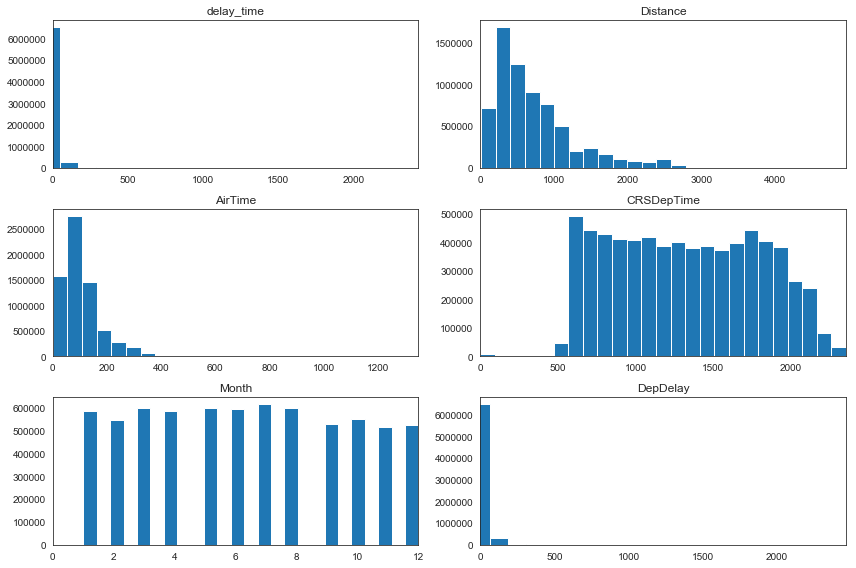

In [51]:
plt.figure(figsize=(12,8))
n = 0

for x in continuous:    
    n=n+1
    plt.subplot(3,2,n)
    plt.hist(df_air[x], bins=25)
    plt.xlim(0,df_air[x].max())
    plt.xlabel('')
    plt.ylabel('')
    
    plt.title(x)
plt.tight_layout()
plt.show()

(-100, 1500)

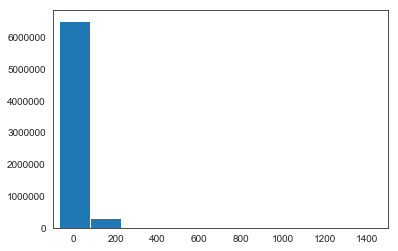

In [29]:
plt.hist(df_air.ArrDelay, bins=20)
plt.xlim(-100, 1500)

### Ideally the airport pairings would all be used but with time and computation restrictions helpful to cut down to the biggest offenders

In [47]:
from sklearn.preprocessing import MinMaxScaler
#from sklearn import neighbors
X = df_air.drop(['delay_flag', 'delay_time','Dest','Origin'], axis=1)
X = pd.get_dummies(X)
y = df_air['delay_flag'].astype('bool')

# Scale Data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

--- 0.1770339012145996 seconds ---


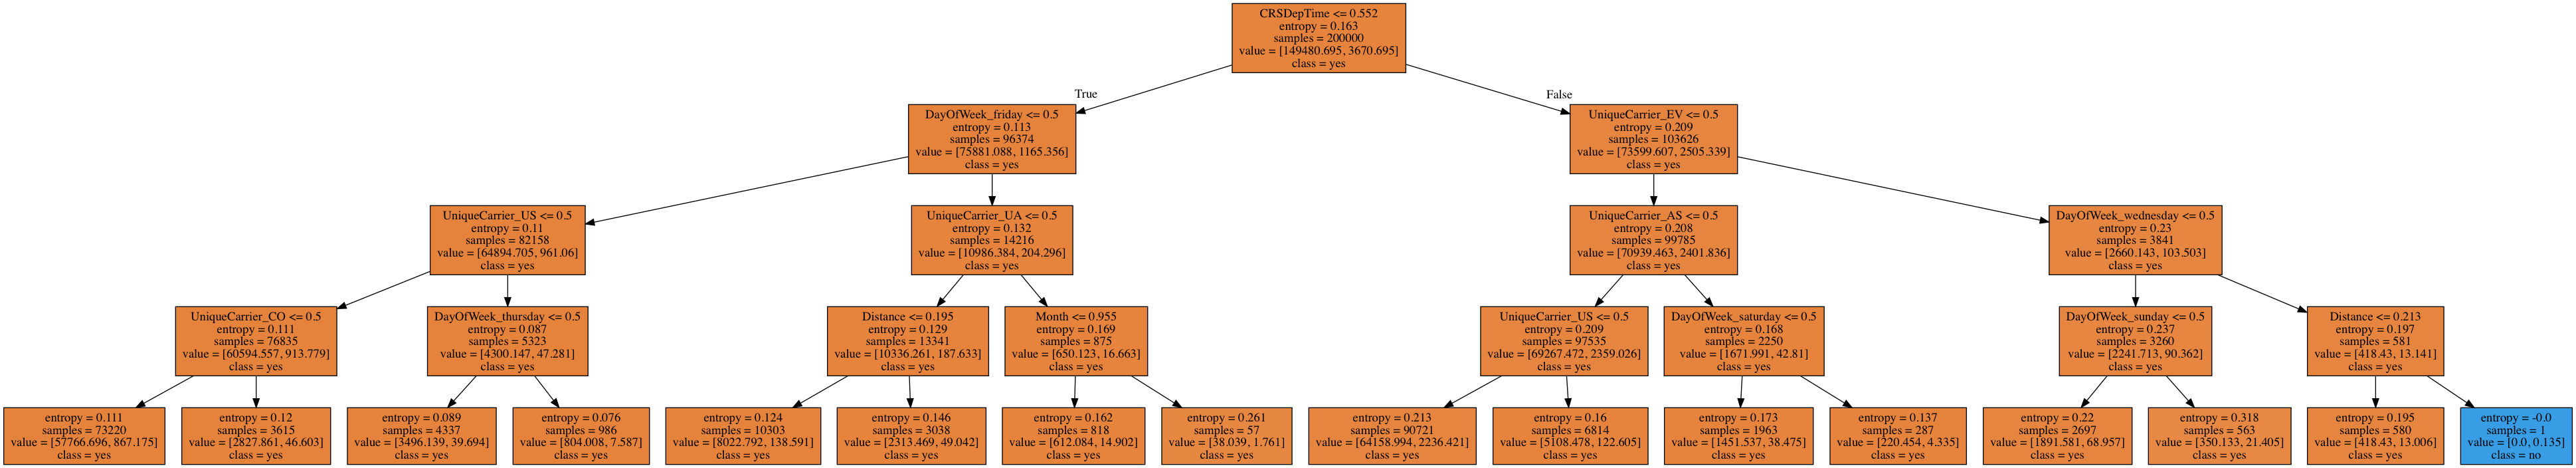

In [99]:
import time
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz

start_time = time.time()

decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4,
    class_weight={'yes':0.135475, 'no':0.864525}
)

decision_tree.fit(X_scaled, y)
print("--- %s seconds ---" % (time.time() - start_time))


# Render Tree
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=['yes', 'no'],
    filled=True
)

graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())


In [147]:
# Instantiate Random forest classifier
forest = RandomForestClassifier(max_depth=4,
                                n_estimators=51,
                                class_weight={True:0.135475, False:0.864525})
cross_val_score(forest, X_scaled, y, scoring='roc_auc', cv=3)

array([0.6655055 , 0.66264677, 0.66429347])

In [117]:
forest.fit(X,y)

RandomForestClassifier(bootstrap=True,
            class_weight={True: 0.135475, False: 0.864525},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [153]:
### Build our model.
# Instantiate Random Forest
forest_grid = RandomForestClassifier(class_weight={True:0.135475, False:0.864525})

# Define the parameter values that I would like to search
n_estimators_range = np.arange(1, 101, 10) # 1- 200
max_depth_range = np.arange(1, 6, 1)
# Create a parameter grip: map the parameter names to the values that should be search
param_grid = dict(n_estimators=n_estimators_range, max_depth=max_depth_range)

# Instantiate the grid
grid = GridSearchCV(forest_grid, param_grid, cv=3, scoring='roc_auc')

In [154]:
start_time = time.time()
# your code
grid.fit(X_scaled, y)
print(time.time() - start_time)

342.02842903137207


In [155]:
print('best score {}'.format(grid.best_score_))
print('n\best parameters {}'.format(grid.best_params_))
print('n\best estimator {}'.format(grid.best_estimator_))

best score 0.6691976308806519
nest parameters {'max_depth': 5, 'n_estimators': 91}
nest estimator RandomForestClassifier(bootstrap=True,
            class_weight={True: 0.135475, False: 0.864525},
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=91, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [156]:
forest = RandomForestClassifier(max_depth=5,
                                n_estimators=91,
                                class_weight={True:0.135475, False:0.864525})
forest_fit = forest.fit(X_scaled, y)

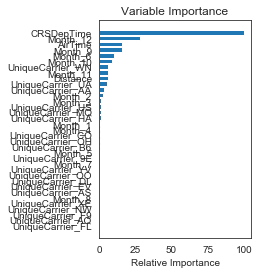

In [149]:
feature_importance = forest.feature_importances_

#  Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [157]:
pd.DataFrame(data={'importance':forest.feature_importances_, 
                   'feature_names':X.columns}).sort_values(by='importance', ascending=False)

,importance,feature_names
2,0.436299,CRSDepTime
26,0.105465,Month_12
1,0.070108,AirTime
24,0.067653,Month_10
0,0.062385,Distance
34,0.052483,Month_9
31,0.041905,Month_6
25,0.028821,Month_11
20,0.028664,UniqueCarrier_WN
27,0.024181,Month_2


In [25]:
### Build our model.
# Instantiate Random Forest
ridge = LogisticRegression(penalty='l2', fit_intercept=True, 
                                class_weight={True:0.135475, False:0.864525})

# Define the parameter values that I would like to search
penalty_range = np.arange(5,15,1) # 1- 200

# Create a parameter grip: map the parameter names to the values that should be search
param_grid = dict(C=penalty_range)

# Instantiate the grid
ridge_grid = GridSearchCV(ridge, param_grid, cv=3, scoring='roc_auc')

In [23]:
start_time = time.time()
# your code
ridge_grid.fit(X_scaled, y)
print(time.time() - start_time)

print('best score {}'.format(ridge_grid.best_score_))
print('n\best parameters {}'.format(ridge_grid.best_params_))
print('n\best estimator {}'.format(ridge_grid.best_estimator_))

19.230340003967285
best score 0.6923350125522733
nest parameters {'C': 9}
nest estimator LogisticRegression(C=9, class_weight={True: 0.135475, False: 0.864525},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
          random_state=None, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False)


In [26]:
start_time = time.time()
# your code
ridge_grid.fit(X, y)
print(time.time() - start_time)

print('best score {}'.format(ridge_grid.best_score_))
print('n\best parameters {}'.format(ridge_grid.best_params_))
print('n\best estimator {}'.format(ridge_grid.best_estimator_))

15.850119829177856
best score 0.599954990788856
nest parameters {'C': 85}
nest estimator LogisticRegression(C=85, class_weight={True: 0.135475, False: 0.864525},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
          random_state=None, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False)


In [32]:
### Build our model.
# Instantiate Random Forest
lasso = LogisticRegression(penalty='l1', fit_intercept=True, 
                                class_weight={True:0.135475, False:0.864525})

# Define the parameter values that I would like to search
penalty_range = np.arange(0.01,5.0,0.5) # 1- 200

# Create a parameter grip: map the parameter names to the values that should be search
param_grid = dict(C=penalty_range)

# Instantiate the grid
lasso_grid = GridSearchCV(lasso, param_grid, cv=3, scoring='roc_auc')

In [33]:
start_time = time.time()
# your code
lasso_grid.fit(X_scaled, y)
print(time.time() - start_time)

print('best score scaled {}'.format(lasso_grid.best_score_))
print('n\best parameters scaled {}'.format(lasso_grid.best_params_))
print('n\best estimator scaled {}'.format(lasso_grid.best_estimator_))

238.94077277183533
best score scaled 0.6920708493017745
nest parameters scaled {'C': 1.01}
nest estimator scaled LogisticRegression(C=1.01, class_weight={True: 0.135475, False: 0.864525},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l1',
          random_state=None, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False)


In [38]:
lasso = LogisticRegression(penalty='l1', C=1.01, 
                           fit_intercept=True, 
                           class_weight={True:0.135475, False:0.864525})
lasso_fit = lasso.fit(X_scaled, y)

# Now lets predict how late a flight will be

In [49]:
from sklearn.preprocessing import MinMaxScaler
#from sklearn import neighbors
df_late = df_air[df_air['delay_flag']==1.0]
X = df_late.drop(['delay_flag', 'delay_time','Dest','Origin'], axis=1)
X = pd.get_dummies(X)
y = df_late['delay_time']

# Scale Data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [59]:
### Build our model.
# Instantiate Random Forest
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score
lasso = Lasso(fit_intercept=True)

# Define the parameter values that I would like to search
penalty_range = np.arange(1.0,22.0,5.0) # 1- 200

# Create a parameter grip: map the parameter names to the values that should be search
param_grid = dict(alpha=penalty_range)

# Instantiate the grid
rgr_grid = GridSearchCV(lasso, param_grid, cv=3, scoring='r2')

In [63]:
start_time = time.time()
# your code
rgr_grid.fit(X, y)
print(time.time() - start_time)

print('best score scaled {}'.format(rgr_grid.best_score_))
print('n\best parameters scaled {}'.format(rgr_grid.best_params_))
print('n\best estimator scaled {}'.format(rgr_grid.best_estimator_))

0.4571399688720703
best score scaled 0.0012513038609757144
nest parameters scaled {'alpha': 1.0}
nest estimator scaled Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


In [71]:
forest_grid = RandomForestRegressor()

# Define the parameter values that I would like to search
n_estimators_range = np.arange(1, 101, 10) # 1- 200
max_depth_range = np.arange(1, 6, 1)
# Create a parameter grip: map the parameter names to the values that should be search
param_grid = dict(n_estimators=n_estimators_range, max_depth=max_depth_range)

# Instantiate the grid
grid = GridSearchCV(forest_grid, param_grid, cv=3)

In [72]:
start_time = time.time()
# your code
grid.fit(X, y)
print(time.time() - start_time)

print('best score scaled {}'.format(grid.best_score_))
print('n\best parameters scaled {}'.format(grid.best_params_))
print('n\best estimator scaled {}'.format(grid.best_estimator_))

90.19558882713318
best score scaled 0.01254367012279244
nest parameters scaled {'max_depth': 5, 'n_estimators': 81}
nest estimator scaled RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=81, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [68]:
from sklearn.ensemble import RandomForestRegressor
rgr = RandomForestRegressor(n_estimators=10,
                            max_depth=10)

cross_val_score(rgr, X, y, cv=3)

array([ 0.00198412, -0.00993682, -0.01915354])